In [1]:
import cellrank as cr
import numpy as np
import pandas as pd

import scanpy as scp
import scvelo as scv
from utils import CELLTYPE_COLOR_DICT
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import sparse
from utils import plot_root_end_point_composition

import os

import warnings

%load_ext jupyter_black

import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [2]:
# Load preprocessed adata
adata = scp.read("adata_CD8_velocity_all.h5ad")

add_clono = False
print(adata.shape)

tcr_adata = scp.read("TCR_data.h5ad")

# Add tcr clonotypes to main adata
adata.obs["Clonotype"] = pd.Categorical(
    [
        tcr_adata.obs.loc[idx]["clone_id"] if idx in tcr_adata.obs.index else pd.NA
        for idx, cell in adata.obs.iterrows()
    ]
)
# And clusters
adata.obs["Clonotype cluster"] = (
    pd.read_csv("clonotype_clusters_kmeans_5_clusters_good.csv")
    .set_index("new_index")["Clonotype cluster"]
    .astype("category")
)

adata.obs["palantir_pseudotime"] = pd.read_csv(
    "CD8_full_palantir_pseudotime.csv"
).set_index("new_index")

(11766, 7109)


<Axes: >

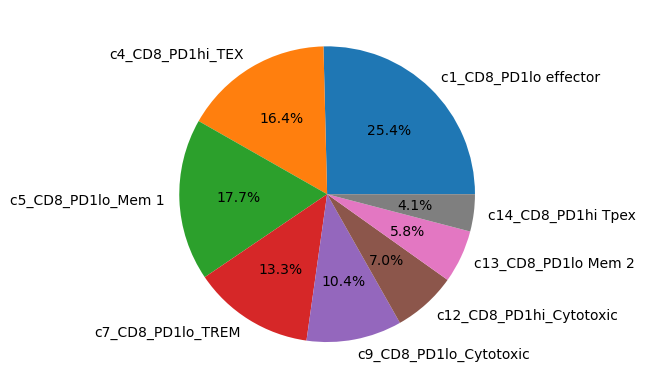

In [3]:
adata.obs.groupby("Cluster label").size().plot.pie(autopct="%1.1f%%")

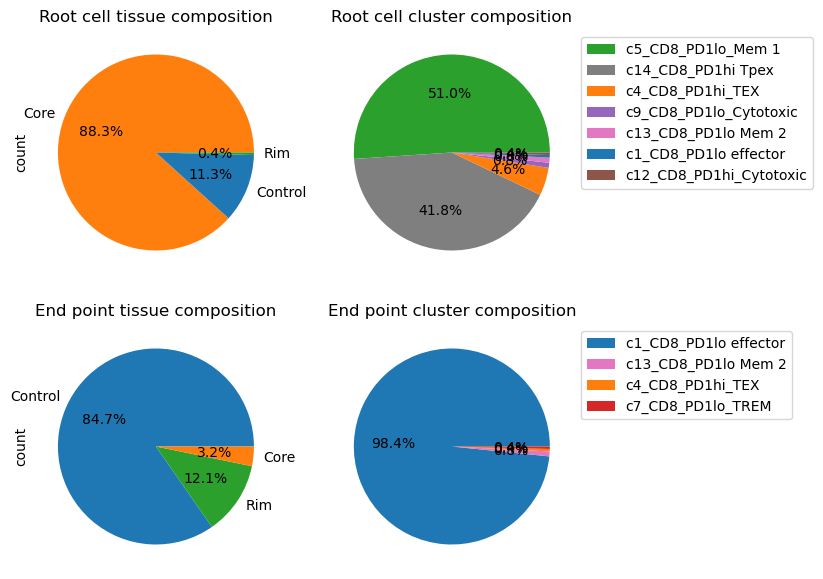

In [4]:
plot_root_end_point_composition(adata)

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


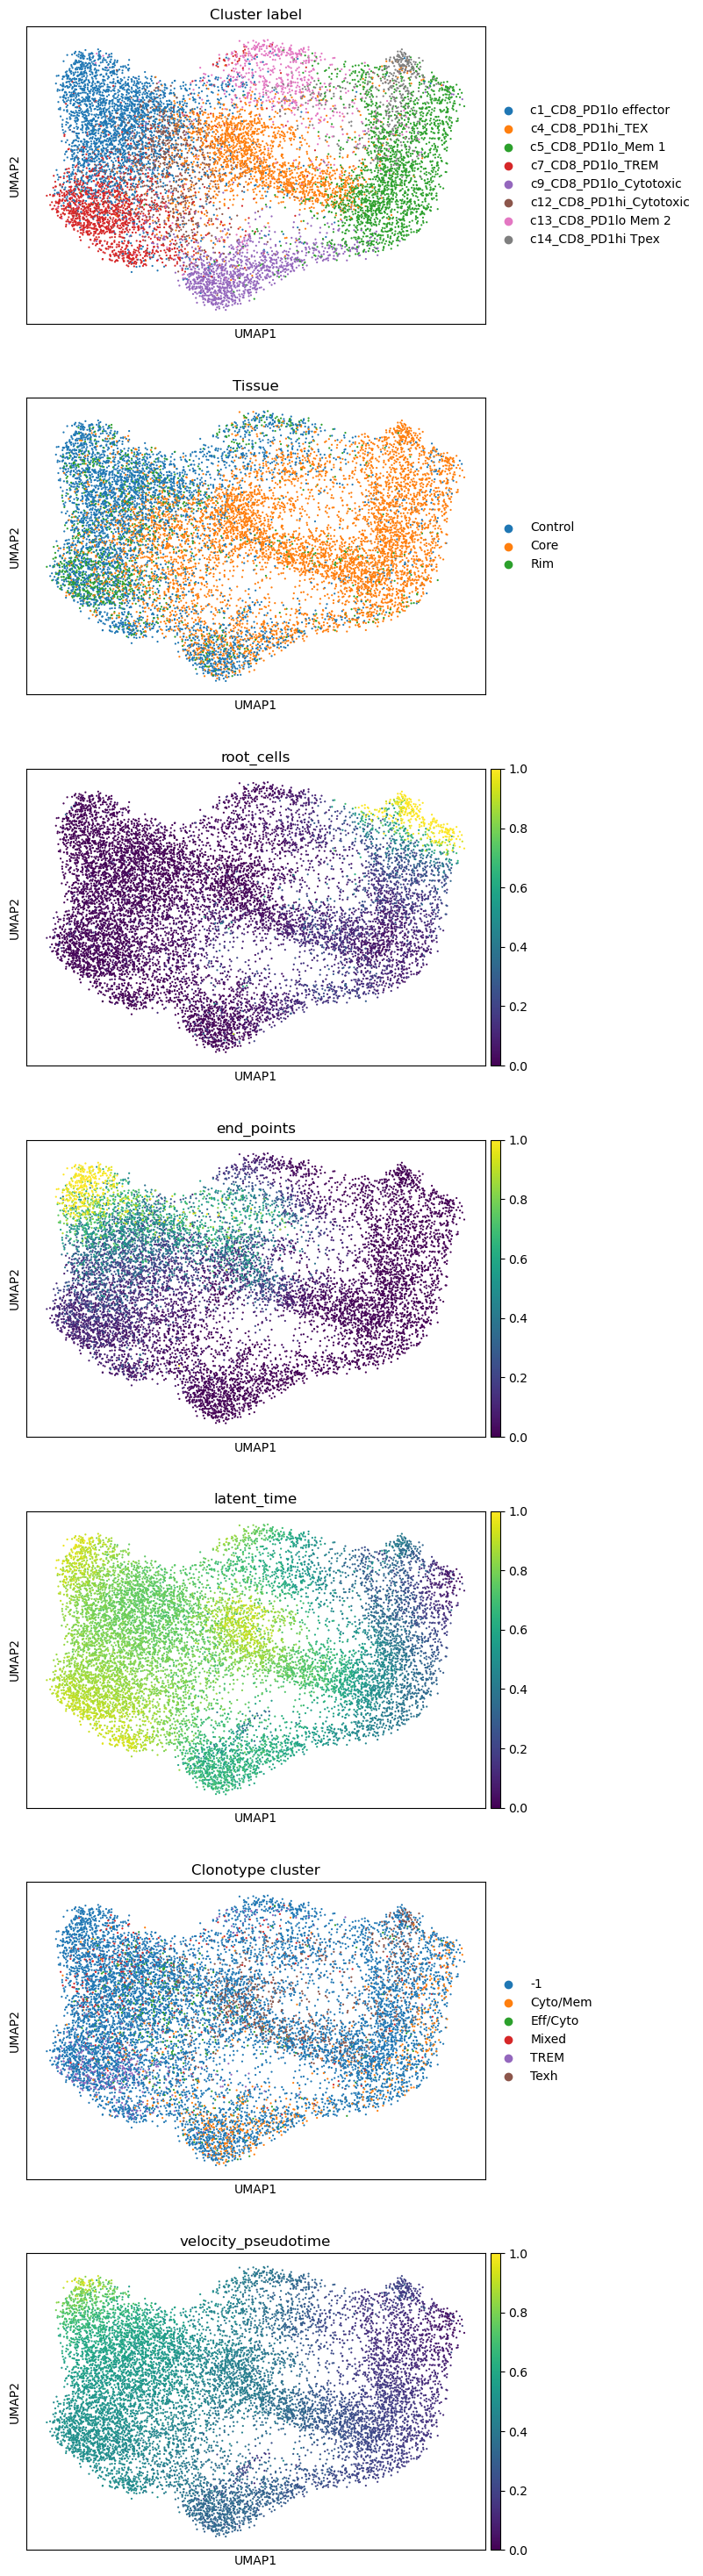

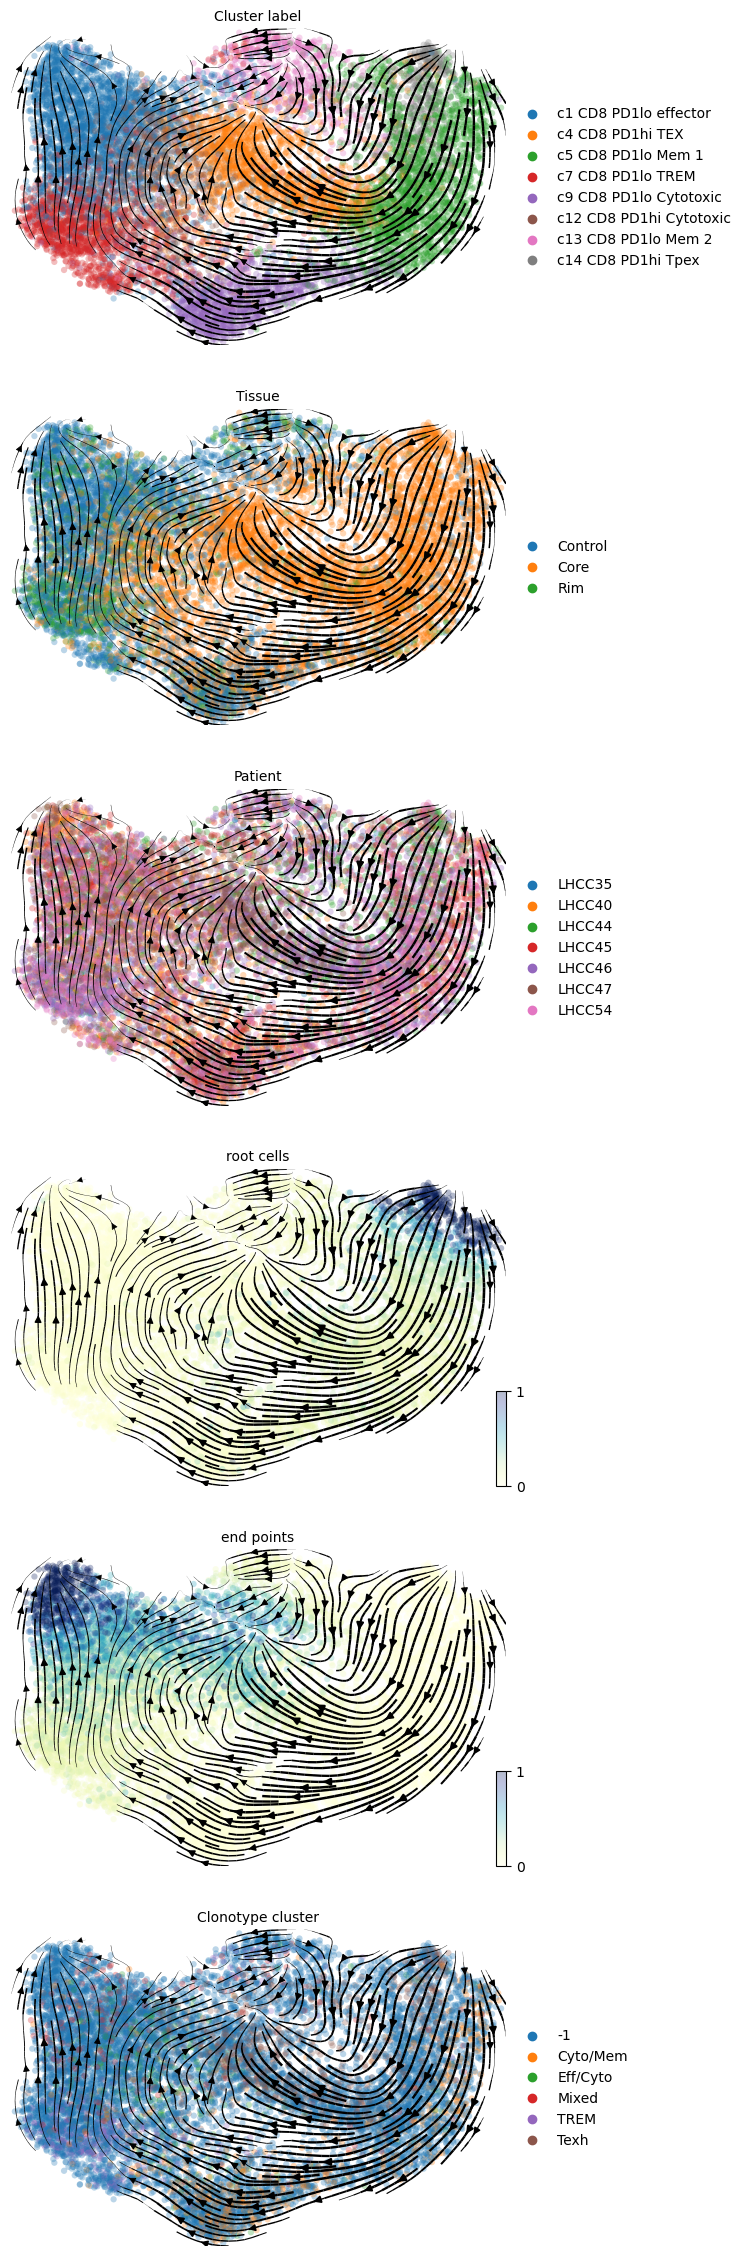

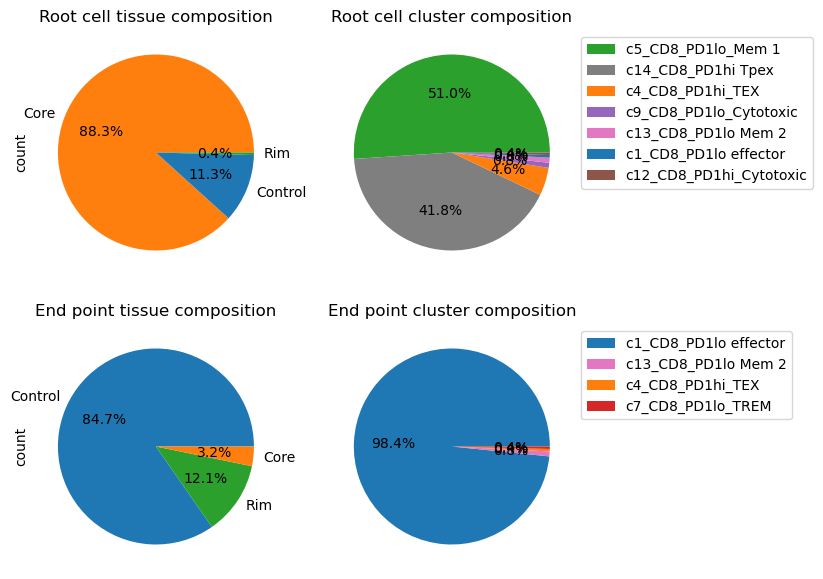

In [5]:
# Visualise velocity
scv.tl.velocity_embedding(adata)

scp.pl.umap(
    adata,
    color=[
        "Cluster label",
        "Tissue",
        "root_cells",
        "end_points",
        "latent_time",
        "Clonotype cluster",
        "velocity_pseudotime",
    ],
    ncols=1,
    legend_loc="right margin",
)

scv.pl.velocity_embedding_stream(
    adata,
    ncols=1,
    color=[
        "Cluster label",
        "Tissue",
        "Patient",
        "root_cells",
        "end_points",
        "Clonotype cluster",
    ],
    color_map="YlGnBu",
    legend_loc="right margin",
)


plot_root_end_point_composition(adata)

In [44]:
adata.obs["Cluster label short"] = adata.obs["Cluster label"].map(
    lambda x: " ".join(x.split("_")[2:])
)


CELLTYPE_COLOR_DICT_SHORT = {}

for cluster, color in CELLTYPE_COLOR_DICT.items():
    CELLTYPE_COLOR_DICT_SHORT[" ".join(cluster.split("_")[2:])] = color

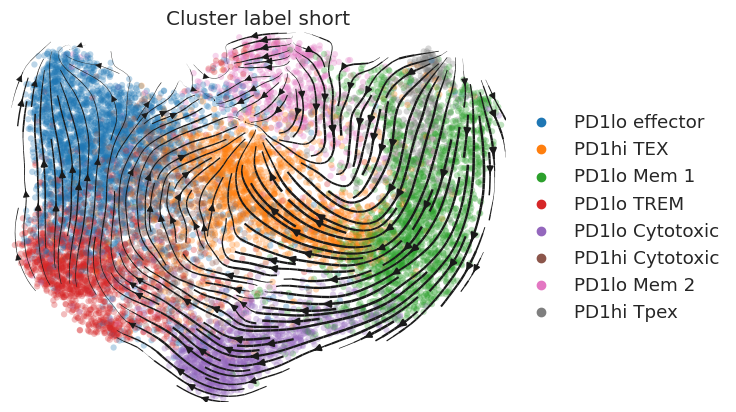

In [45]:
scv.pl.velocity_embedding_stream(
    adata,
    ncols=1,
    color=[
        "Cluster label short",
    ],
    color_map="YlGnBu",
    legend_loc="right margin",
    palette=CELLTYPE_COLOR_DICT_SHORT,
)

<Axes: xlabel='latent_time', ylabel='Cluster label short'>

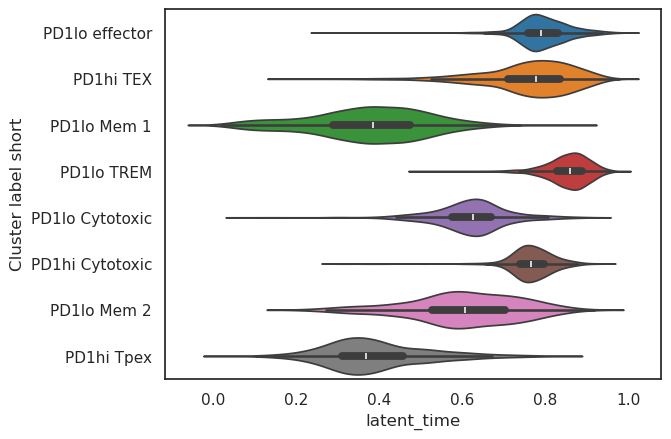

In [57]:
sns.set(font_scale=1)
sns.set_style("white")
sns.violinplot(
    adata.obs,
    x="latent_time",
    y="Cluster label short",
    palette=CELLTYPE_COLOR_DICT_SHORT,
)

  0%|          | 0/11766 [00:00<?, ?cell/s]

  0%|          | 0/11766 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


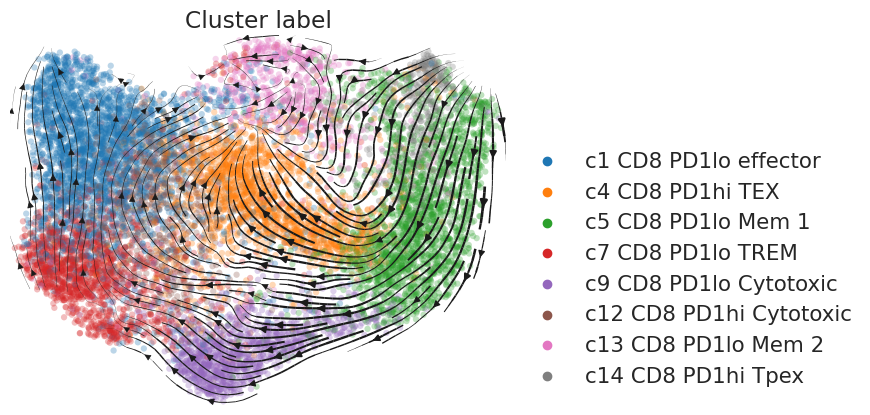

In [30]:
# Compute the RNA velocity kernel and plot projection
vk = cr.kernels.VelocityKernel(adata, backward=False)
vk.compute_transition_matrix()
vk.plot_projection(recompute=True, color="Cluster label", legend_loc="lower right")

In [31]:
# Hacky solution to use Cellranks random walk functions to also capture terminal states, rather than just plot
def plot_cellrank_random_walk_term_state_composition(
    adata,
    kernel,
    start_cluster,
    cluster_label_column,
    end_cluster=None,
    n_sims=500,
    max_iter=50,
    seed=0,
):
    from cellrank.kernels.utils import RandomWalk

    end_dict = (
        {cluster_label_column: end_cluster} if (end_cluster is not None) else None
    )
    # run simulation
    rw = RandomWalk(
        adata,
        kernel.transition_matrix,
        start_ixs={cluster_label_column: start_cluster},
        stop_ixs=end_dict,
    )
    sims = rw.simulate_many(
        n_sims=n_sims,
        max_iter=max_iter,
        seed=seed,
        n_jobs=None,
        backend="loky",
        successive_hits=0,
        show_progress_bar=True,
    )

    # select final cells
    term_cells = [a[-1] for a in sims]
    term_cells_adata = adata.obs.iloc[term_cells]

    # plot a piechart
    term_cells_adata.groupby(cluster_label_column).size().plot.pie(autopct="%1.1f%%")

In [85]:
# Utility function for the above
def run_random_walks(
    adata,
    kernel,
    start_cluster,
    cluster_label_column,
    end_cluster=None,
    n_sims=500,
    max_iter=20,
    seed=0,
):

    end_dict = (
        {cluster_label_column: end_cluster} if (end_cluster is not None) else None
    )

    kernel.plot_random_walks(
        n_sims=n_sims,
        max_iter=max_iter,
        start_ixs={cluster_label_column: start_cluster},
        stop_ixs=end_dict,
    )
    plt.show()
    plot_cellrank_random_walk_term_state_composition(
        adata,
        kernel,
        end_cluster=end_cluster,
        start_cluster=start_cluster,
        cluster_label_column=cluster_label_column,
        n_sims=500,
        max_iter=max_iter,
        seed=0,
    )

  0%|          | 0/500 [00:00<?, ?sim/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


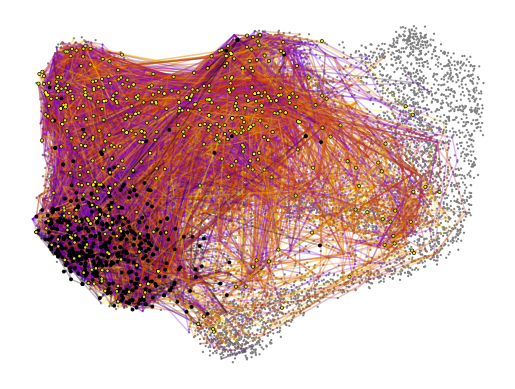

  0%|          | 0/500 [00:00<?, ?sim/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


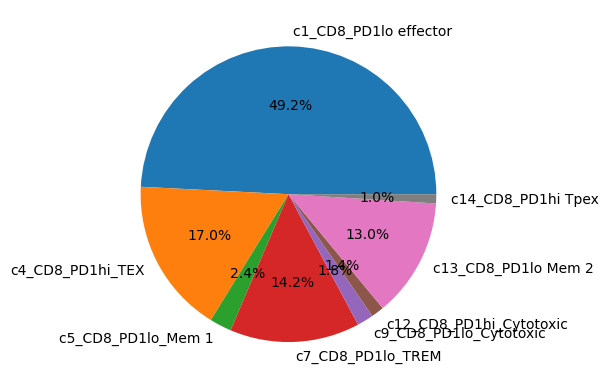

In [87]:
run_random_walks(
    adata,
    vk,
    start_cluster="c7_CD8_PD1lo_TREM",
    cluster_label_column="Cluster label",
    max_iter=50,
)

  0%|          | 0/500 [00:00<?, ?sim/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


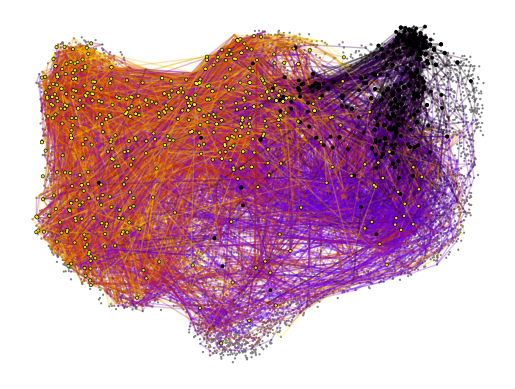

  0%|          | 0/500 [00:00<?, ?sim/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


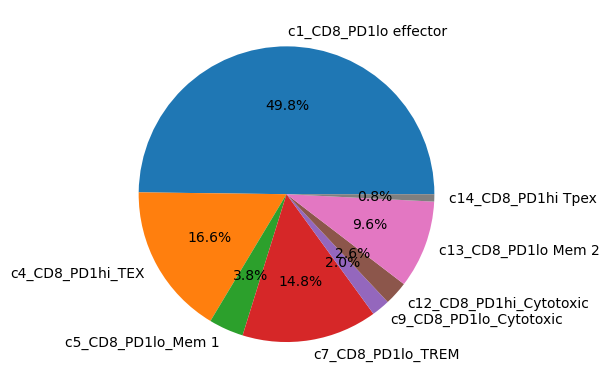

In [89]:
run_random_walks(
    adata,
    vk,
    start_cluster="c14_CD8_PD1hi Tpex",
    cluster_label_column="Cluster label",
    max_iter=50,
)

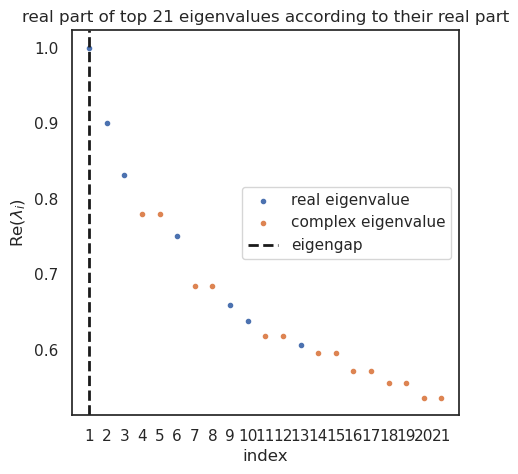

In [58]:
# Run GPCCA
g = cr.estimators.GPCCA(vk)
g.compute_schur(n_components=20, method="krylov", verbose=True)
g.plot_spectrum(real_only=True, legend_loc="center right")

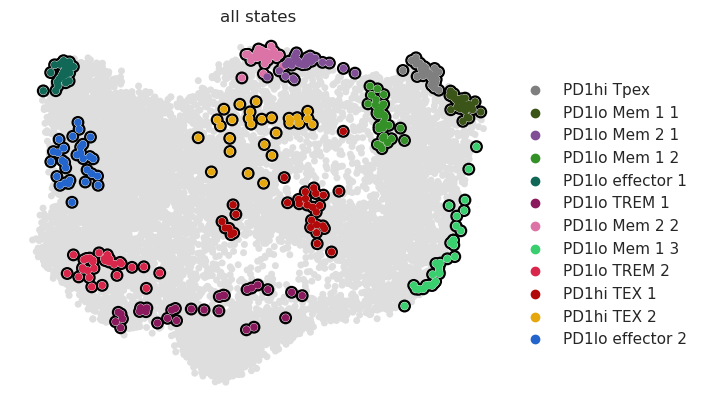

In [60]:
# Find optimal number of states
g.fit(n_states=[5, 15], cluster_key="Cluster label short", n_cells=30, verbose=True)
g.plot_macrostates(which="all", legend_loc="right", s=100)

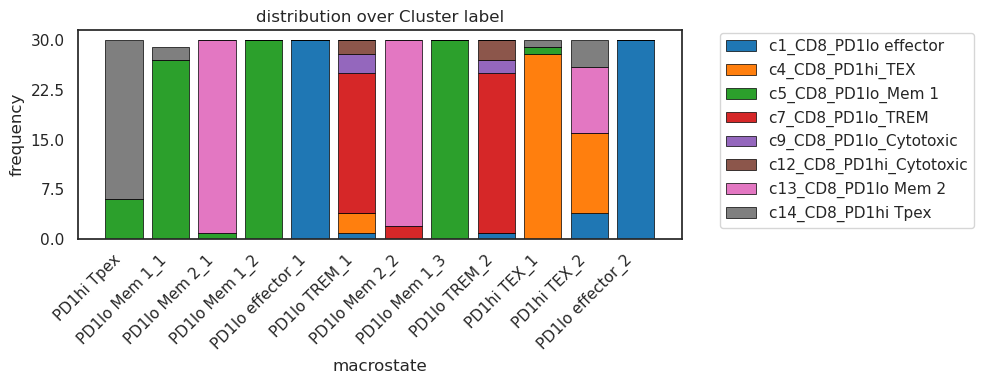

In [61]:
g.plot_macrostate_composition(key="Cluster label", figsize=(10, 4))

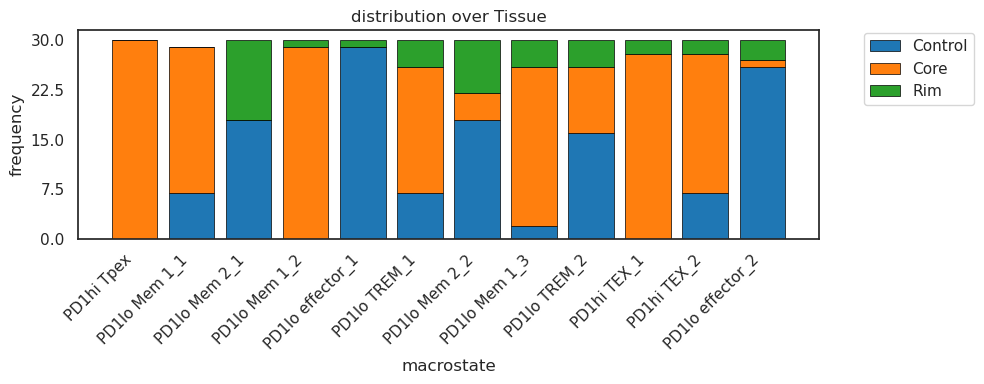

In [62]:
g.plot_macrostate_composition(key="Tissue", figsize=(10, 4))

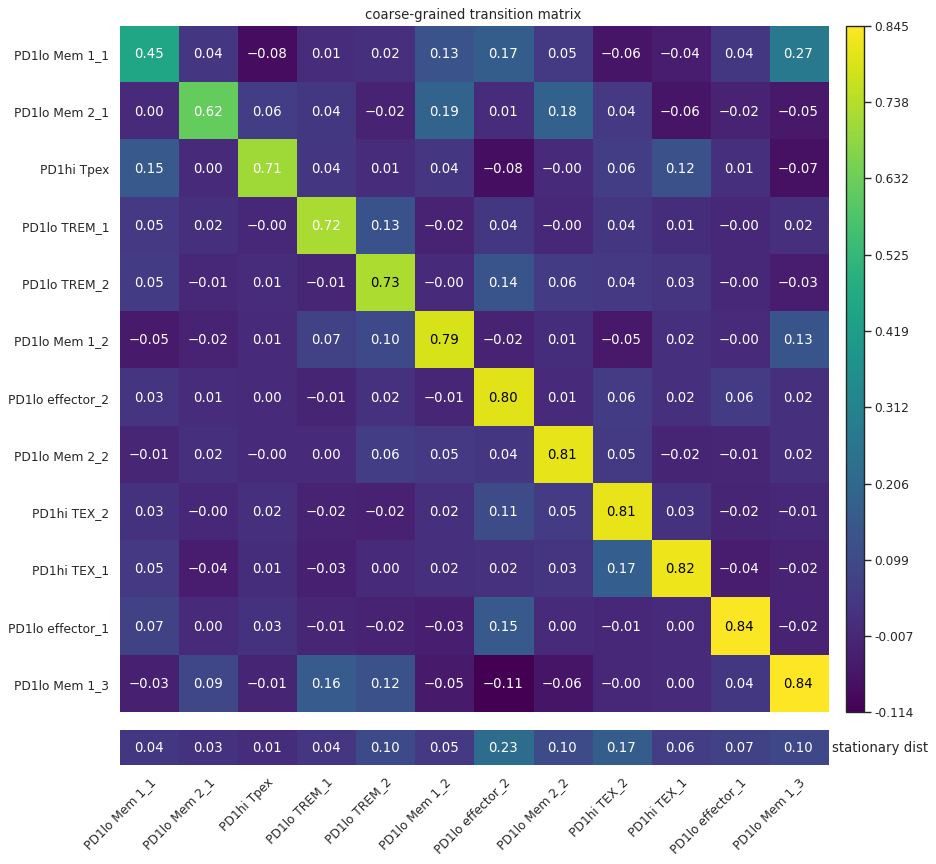

In [63]:
g.plot_coarse_T(figsize=(12, 12))

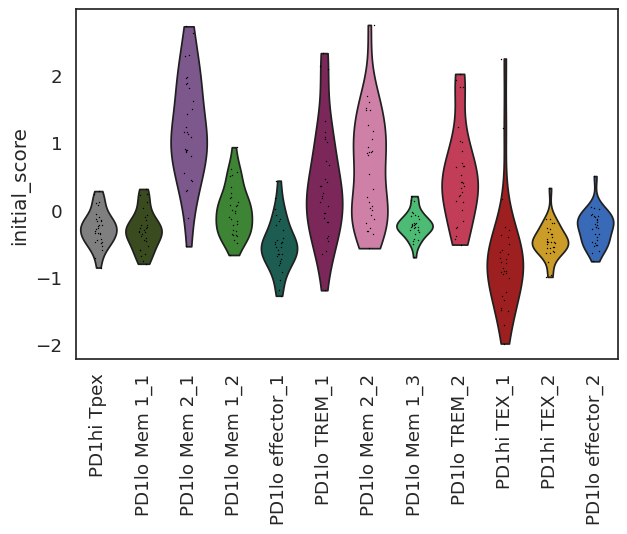

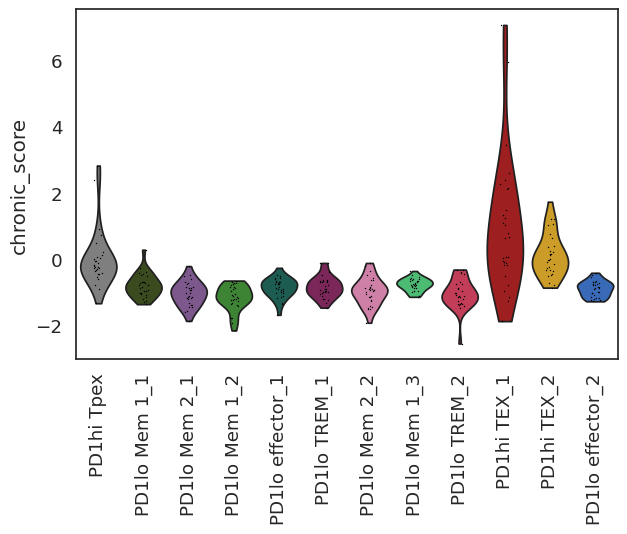

In [50]:
scp.tl.score_genes(
    adata,
    gene_list=[
        "IL6ST",
        "XCL1",
        "CD160",
        "CD200",
        "BTLA",
        "GNG4",
        "XCL1",
        "XCL2",
        "IL7R",
        "CCR7",
        "KLF2",
        "LEF1",
        "TCF7",
        "CD44",
        "SELL",
        "FOSB",
    ],
    score_name="initial_score",
)

gene_list = [
    "CD160",
    "XCL2",
    "XCL1",
    "CD200",
    "IL6ST",
    "SELL",
    "LEF1",
    "TCF7",
    "CD44",
    "CCR7",
    "KLF2",
    "FOSB",
]


scp.tl.score_genes(
    adata,
    gene_list=[
        "PDCD1",
        "LAG3",
        "CTLA4",
        "HAVCR2",
        "ENTPD1",
        "TIGIT",
        "CD38",
        "DUSP4",
        "TOX2",
        "LAYN",
        "CXCL13",
    ],
    score_name="chronic_score",
)

adata.obs["macrostates"] = g.macrostates
adata.uns["macrostates_colors"] = g.macrostates_memberships.colors


scp.pl.violin(
    adata, keys="initial_score", groupby="macrostates", rotation=90, legend=False
)


scp.pl.violin(
    adata, keys="chronic_score", groupby="macrostates", rotation=90, legend=False
)

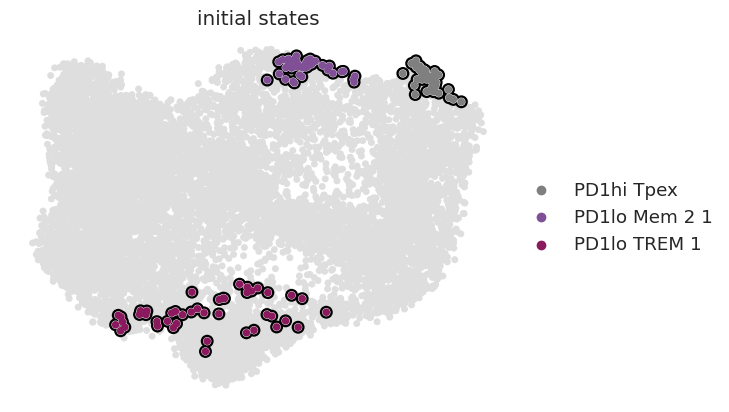

In [51]:
g.predict_initial_states(n_states=3, n_cells=45, allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100)

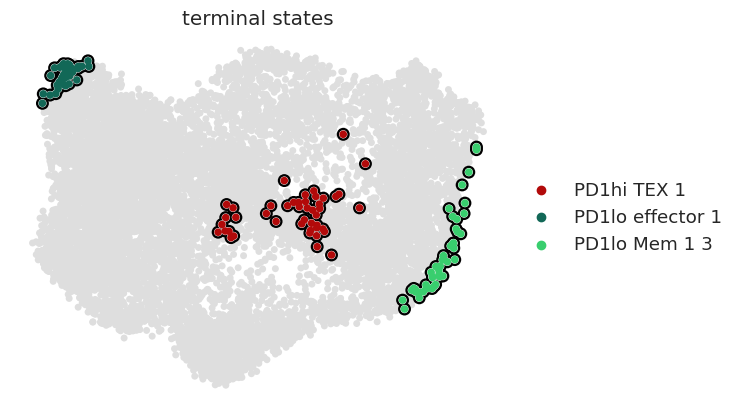

In [52]:
g.predict_terminal_states(n_cells=45, method="top_n", n_states=3, allow_overlap=True)

# g.plot_macrostates(which="initial", legend_loc="right", s=100)
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

  0%|          | 0/3 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


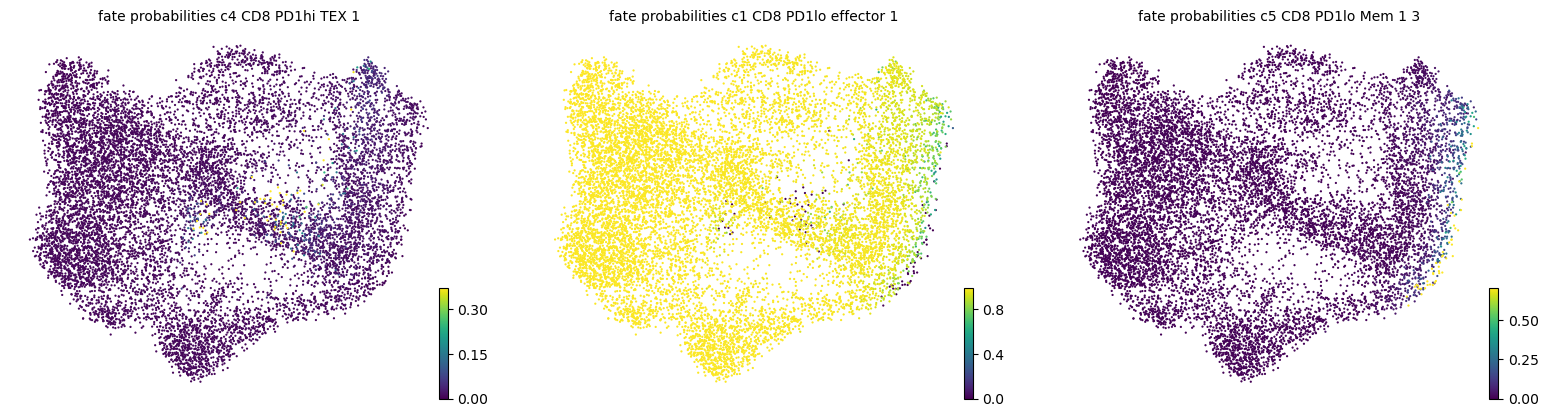

In [27]:
g.compute_fate_probabilities(use_petsc=True, solver="gmres", n_jobs=1)
g.plot_fate_probabilities(same_plot=False)